Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.normalization.batch_normalization import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
root_path = '/content/gdrive/MyDrive/Skin_cancer'
data_dir_train = pathlib.Path(root_path+'/Train')
data_dir_test = pathlib.Path(root_path+'/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  label_mode='categorical',
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

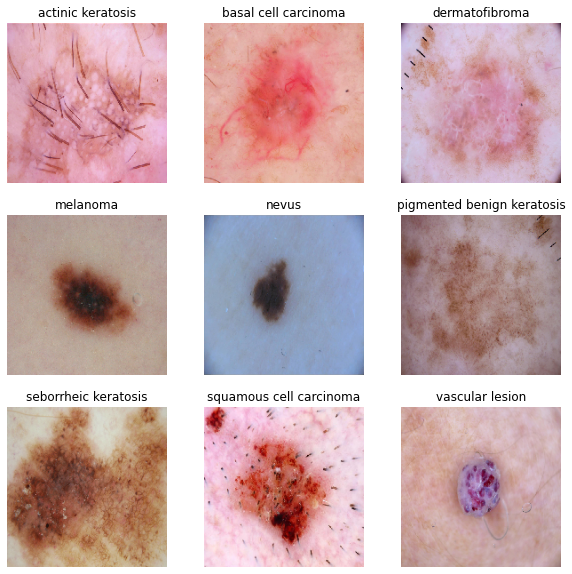

In [9]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(10, 10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
#preprocessing_layers = [
 #   tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
#]

In [12]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))



#model.add(Dense(512, activation='relu'))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(len(class_names)))
#model.add(layers.Dense(len(class_names),activation='softmax'))
model.add(Activation('softmax'))

## Number of classes is 9

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 176, 176, 32)     9248      
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 88, 88, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 86, 86, 64)       18496     
 pper)                                                  

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 656s 2s/step - loss: 2.0417 - accuracy: 0.2165 - val_loss: 1.9133 - val_accuracy: 0.3020
Epoch 2/20
56/56 [==============================] - 3s 61ms/step - loss: 1.8819 - accuracy: 0.3192 - val_loss: 1.7155 - val_accuracy: 0.4340
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.6359 - accuracy: 0.4235 - val_loss: 1.5287 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.4833 - accuracy: 0.4939 - val_loss: 1.4624 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 3s 61ms/step - loss: 1.3896 - accuracy: 0.5028 - val_loss: 1.4131 - val_accuracy: 0.4787
Epoch 6/20
56/56 [==============================] - 3s 61ms/step - loss: 1.2603 - accuracy: 0.5519 - val_loss: 1.4943 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.2115 - accuracy: 0.5686 - val_loss: 1.7279 - val_accuracy: 0.4765
Epoch 8/20
56

### Visualizing training results

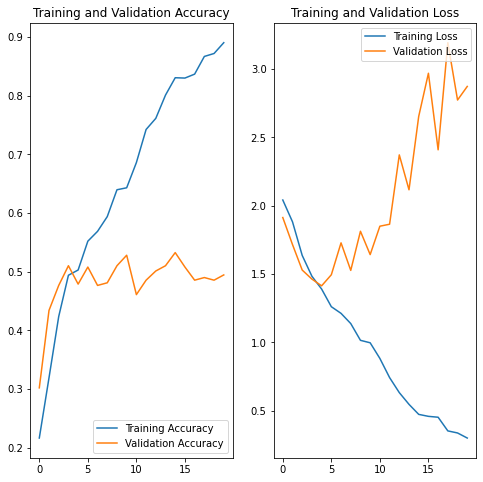

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [17]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


# Thus we can clearly that model Overfit and we need to chose right data augumentation strategy

14/14 [==============================] - 0s 24ms/step - loss: 2.8733 - accuracy: 0.4944
Accuracy:  0.9162946343421936
Validation Accuracy:  0.49440714716911316
Loss:  0.24110272526741028
Validation Loss 2.8733205795288086


### Write your findings here
Test accuracy is very high whereas validation accuracy is quite, so looks like model clearly overfits.

In [18]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, 
#choose an appropriate data augumentation strategy. 
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


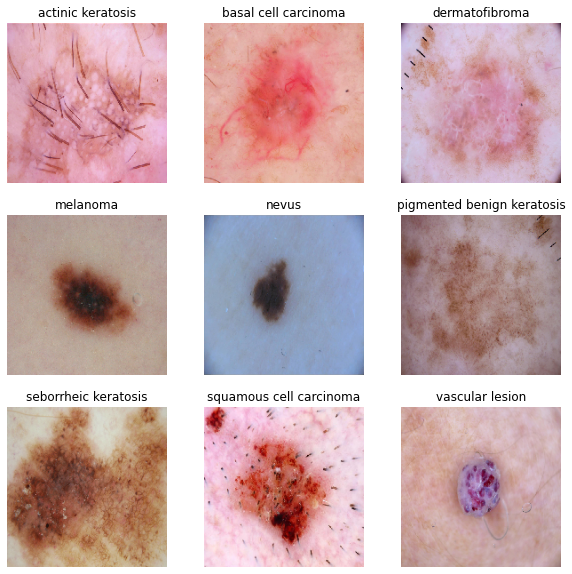

In [19]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

plt.figure(figsize=(10, 10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")



### Todo:
### Create the model, compile and train the model


In [20]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
#Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))




### Compiling the model

In [21]:
## Your code goes here
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_11 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_12 (ModuleWr  (None, 180, 180, 32)     9248      
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

In [23]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
#batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])


Epoch 1/20
14/14 [==============================] - 76s 5s/step - loss: 2.1027 - accuracy: 0.3820 - val_loss: 1.2892 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 2/20
14/14 [==============================] - 31s 2s/step - loss: 1.0217 - accuracy: 0.4573 - val_loss: 1.5279 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 3/20
14/14 [==============================] - 31s 2s/step - loss: 0.9925 - accuracy: 0.4517 - val_loss: 1.2281 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/20
14/14 [==============================] - ETA: 0s - loss: 0.9844 - accuracy: 0.4820
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 [==============================] - 31s 2s/step - loss: 0.9844 - accuracy: 0.4820 - val_loss: 1.2137 - val_accuracy: 0.3542 - lr: 0.0010
Epoch 5/20
14/14 [==============================] - 31s 2s/step - loss: 0.9767 - accuracy: 0.4820 - val_loss: 1.1695 - val_accuracy: 0.3333 - lr: 5.0000e-04
Epoch 6/20
14/14 [==============================] - 31s 2s/step - loss: 

### Visualizing the results

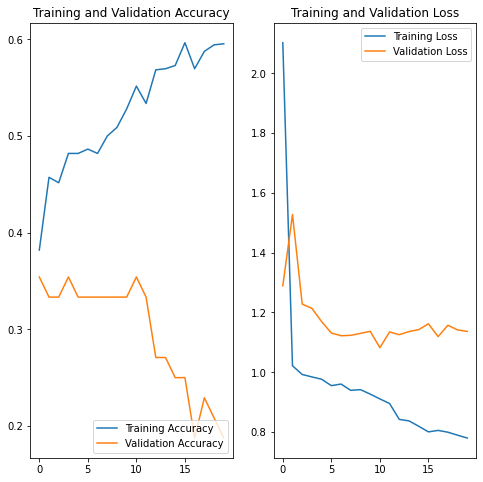

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Validation accuracy has increased as compared to first model and Train accuracy has decreased a bit, so clearly overfitting has decreased. But still there is much difference between Train and Validation accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

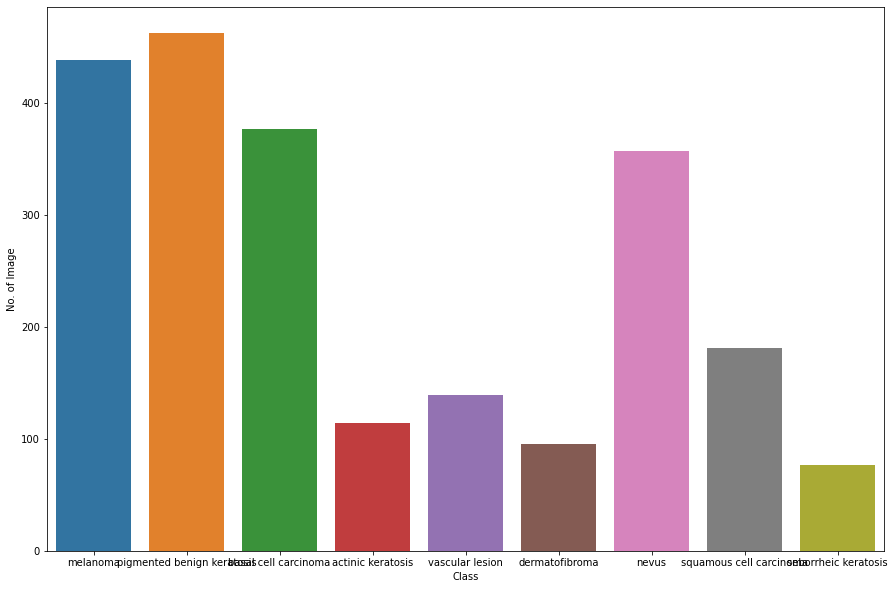

In [26]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)


#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(15, 10))
sns.barplot(y="No. of Image", x="Class", data=df,
            label="Class")

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? 'seborrheic keratosis'
#### - Which classes dominate the data in terms proportionate number of samples? 'pigmented benign keratosis'


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
path_to_training_dataset='/content/gdrive/MyDrive/Skin_cancer/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA799B685D0>: 100%|██████████| 500/500 [00:20<00:00, 24.15 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA799B6EED0>: 100%|██████████| 500/500 [00:21<00:00, 23.62 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA79AD0FE50>: 100%|██████████| 500/500 [00:21<00:00, 23.05 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA799AD2090>: 100%|██████████| 500/500 [01:29<00:00,  5.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FA799B3A450>: 100%|██████████| 500/500 [01:16<00:00,  6.52 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA79AD0F950>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA79A671F10>: 100%|██████████| 500/500 [00:41<00:00, 12.07 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA799AE3A50>: 100%|██████████| 500/500 [00:18<00:00, 27.53 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA799BE8E10>: 100%|██████████| 500/500 [00:17<00:00, 27.98 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010393.jpg_fa2e8e96-0f34-4277-9bab-39bf9ea20268.jpg',
 '/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010872.jpg_8001a73e-3a93-49ca-bcd1-7c21f755eed1.jpg',
 '/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000309.jpg_fe50f1e7-035f-4597-ad91-d03cd623bce4.jpg',
 '/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000139.jpg_af02ab75-2699-4ab9-b346-fd5cc643d2db.jpg',
 '/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0010251.jpg_be86c3dd-c082-4e86-9473-41b1196f4106.jpg',
 '/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0009989.jpg_0d5e0dd1-2eaa-488b-8a7e-d1f1ec64bdd7.jpg',
 '/content/gdrive/MyDrive/Skin_cancer/Train/melanoma/output/melanoma_original_ISIC_0000294.jpg_ee81a136-ddae-490e-b80d-15b07c8dd343.jpg',
 '/content/gdrive/MyDrive/Skin_can

In [31]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [33]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df =df2

In [34]:
new_df['Label'].value_counts()

melanoma                      500
pigmented benign keratosis    500
basal cell carcinoma          500
actinic keratosis             500
vascular lesion               500
dermatofibroma                500
nevus                         500
squamous cell carcinoma       500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [35]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [36]:
data_dir_train='/content/gdrive/MyDrive/Skin_cancer/Train/'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical',
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [38]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 89, 89, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [39]:
## your code goes here
optimizer = 'Adam'

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])


#### **Todo:**  Train your model

In [40]:
epochs = 30
## Your code goes here, use 30 epochs.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=5, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

#batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/30
169/169 [==============================] - 32s 178ms/step - loss: 5.2985 - accuracy: 0.2695 - val_loss: 5.1237 - val_accuracy: 0.0943 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 29s 168ms/step - loss: 2.8259 - accuracy: 0.2925 - val_loss: 3.8028 - val_accuracy: 0.1975 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 29s 169ms/step - loss: 2.0457 - accuracy: 0.3902 - val_loss: 2.0814 - val_accuracy: 0.3088 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 29s 168ms/step - loss: 1.6069 - accuracy: 0.4496 - val_loss: 1.8087 - val_accuracy: 0.4016 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 29s 169ms/step - loss: 1.4396 - accuracy: 0.4968 - val_loss: 13.2301 - val_accuracy: 0.1767 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 29s 168ms/step - loss: 1.3490 - accuracy: 0.5245 - val_loss: 1.8679 - val_accuracy: 0.5204 - lr: 0.0010
Epoch 7/30
169/169 [==============================]

#### **Todo:**  Visualize the model results

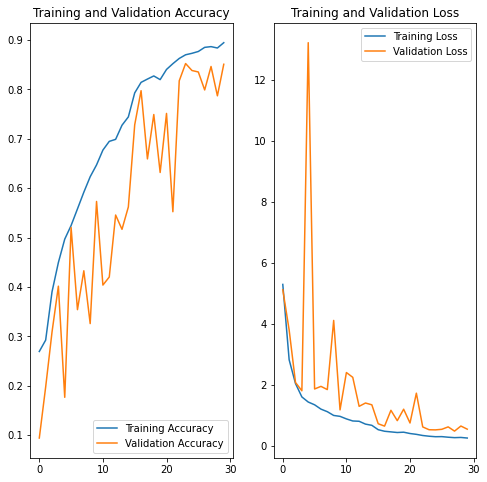

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 6s 110ms/step - loss: 0.5492 - accuracy: 0.8508
Accuracy:  0.9493694305419922
Validation Accuracy:  0.8507795333862305
Loss:  0.12521010637283325
Validation Loss 0.5491746664047241


#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Yes class rebalance helped in improving the results. Also difference between Training and Validation accuracy is also reduced and we have attained a high level of accuracy.
We can run the same model on Test data to find out how it is behaving on unseen data.